# Feature Extraction

This chapter is a deep-dive on the most frequently used dimensionality reduction algorithm, Principal Component Analysis (PCA). You'll build intuition on how and why this algorithm is so powerful and will apply it both for data exploration and data pre-processing in a modeling pipeline. You'll end with a cool image compression use case.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## Feature Extraction

**Feature selection vs. extraction**
  
In the previous two chapters we looked into feature selection where some features were simply dropped completely. Feature extraction is different in the sense that it creates new features, which are in fact combinations of the original ones. There are powerful algorithms that will calculate the new features in a way that as much information as possible is preserved, but before we get into those, let's look at more simple feature extraction. When you have good understanding of the features in your dataset you can sometimes combine multiple features into a new feature that makes the original ones obsolete.
  
![Alt text](../_images/feature-select-extract.png)  

**Feature generation - BMI**
  
Take for instance the body mass index or BMI we've worked with before. Its a measure on whether a person is under- or overweight regardless of their height; and can be calculated by dividing a person's weight by the square of the height. If we build a diabetes model on this data the height and weight features by themselves might be obsolete once we have the BMI. And we could drop them from the dataset with the drop method to reduce dimensionality.
  
**Feature generation - averages**
  
Imagine that our body measurement dataset would have measurements of both left and right leg lengths. For most applications it would be sufficient to reduce these two features into a single leg length feature. We could create such a feature with the DataFrame's `.mean()` method with the axis argument equal to one and then once again drop the original features.
  
**Cost of taking the average**
  
Taking the average of two features comes with the cost of losing some information. In this case the cost is small since the features are so similar, but let's zoom in on this data to identify it. We can now see the differences between both features more clearly. When we add a line for where the two features are equal it becomes easy to identify people with different leg lengths. The cost of taking the average is then that the average leg length for the three people in the red rectangle is the same. You lose the information on the difference in leg lengths.
  
**Intro to PCA**
  
Now let's take a step back and look at a different data sample with hand lengths versus feet lengths. Instead of taking the mean of both features we'll explore an alternative technique. For this technique it's important to scale the features first, so that their values are easier to compare. We do this with sklearn's `StandardScaler()`. The strongest pattern in this dataset is that people with big feet also tend to have big hands. What we could do is add a reference point to the very center of the point cloud, and then point a vector in the direction of this strongest pattern. People with a positive value for this vector have relatively long hands and feet, and people with a negative value have relatively short ones.  
We could add a second vector perpendicular to the first one to account for the rest of the variance in this dataset. People with a positive value for this second vector have relatively long feet compared to their hand length and people with a negative value have relatively big hands. Every point in this dataset could be described by multiplying and then summing these two perpendicular vectors. We've essentially created a new reference system aligned with the variance in the data. The coordinates that each point has in this new reference system are called principal components, and they are the foundation of principal component analysis or PCA which is the main topic of this chapter.

### Manual feature extraction I

You want to compare prices for specific products between stores. The features in the pre-loaded dataset sales_df are: storeID, product, quantity and revenue. The quantity and revenue features tell you how many items of a particular product were sold in a store and what the total revenue was. For the purpose of your analysis it's more interesting to know the average price per product.

In [2]:
# Loading the dataframe
sales_df = pd.read_csv('../_datasets/grocery_sales.csv')
sales_df.head()

,storeID,product,quantity,revenue
0,A,Apples,1811,9300.6
1,A,Bananas,1003,3375.2
2,A,Oranges,1604,8528.5
3,B,Apples,1785,9181.0
4,B,Bananas,944,3680.2


In [3]:
# Calculate the price from the quantity sold and revenue
sales_df['price'] = sales_df['revenue'] / sales_df['quantity']

# Drop the quantity and revenue features
reduced_df = sales_df.drop(['quantity', 'revenue'], axis=1)

# Display
reduced_df.head()

,storeID,product,price
0,A,Apples,5.135616
1,A,Bananas,3.365105
2,A,Oranges,5.317020
3,B,Apples,5.143417
4,B,Bananas,3.898517


When you understand the dataset well, always check if you can calculate relevant features and drop irrelevant ones.

### Manual feature extraction II

You're working on a variant of the ANSUR dataset, height_df, where a person's height was measured 3 times. Add a feature with the mean height to the dataset using the `.mean()` method with axis=1., then drop the 3 original features.

In [4]:
# Loading df
height_df = pd.read_csv('../_datasets/height_df.csv')
height_df.head()

,weight_kg,height_1,height_2,height_3
0,81.5,1.78,1.80,1.80
1,72.6,1.70,1.70,1.69
2,92.9,1.74,1.75,1.73
3,79.4,1.66,1.68,1.67
4,94.6,1.91,1.93,1.90


In [5]:
# Calculate the mean height
height_df['height'] = height_df[['height_1', 'height_2', 'height_3']].mean(axis=1)

# Drop the 3 original height features
reduced_df = height_df.drop(['height_1', 'height_2', 'height_3'], axis=1)

# Display
reduced_df.head()

,weight_kg,height
0,81.5,1.793333
1,72.6,1.696667
2,92.9,1.740000
3,79.4,1.670000
4,94.6,1.913333


You've calculated a new feature that is still easy to understand compared to, for instance, principal components.

### Principal component intuition

![Alt text](../_images/pca-intuition.png)  
  
After standardizing the lower and upper arm lengths from the ANSUR dataset we've added two perpendicular vectors that are aligned with the main directions of variance. We can describe each point in the dataset as a combination of these two vectors multiplied with a value each. These values are then called principal components.
  
**Question**
  
Which of the following statements is true?
  
- [x] People with a negative component for the yellow vector have long forearms relative to their upper arms.
  
- [ ] People with a positive component for the yellow vector have long forearms relative to their upper arms.
  
- [ ] People with a negative component for the red vector have above average arm lengths.
  
- [ ] People with a positive component for the red vector have below average arm lengths.
  
Correct! You now understand the basic concept of principal components!

## Principal component analysis

Let's take a deeper look into principal component analysis.
  
**PCA concept**
  
We already saw that you can describe the information captured by two features by using two perpendicular vectors that are aligned with the variance in the data. For instance the point highlighted here has coordinates 2.7 and 1 in the original hand length versus foot length reference system.
  
![Alt text](../_images/pca-coord.png)  
  
But we could just as well describe this point using multiplications of the vectors. In this case it would be 2 times the red vector and minus 1 times the yellow vector. We call these values the first and second principal components respectively, where the red one is most important as it is aligned with the biggest source of variance in the data. We can calculate these principal components for all points in the dataset with sklearn's `PCA()` class.
  
![Alt text](../_images/pca.png)  
  
**Calculating the principal components**
  
But before we do this, we have to scale the values with the `StandardScaler()`. PCA can really underperform if you don't do this. We can then create our `PCA()` instance and apply the `.fit_transform()` method to the scaled data to calculate the two principal components.
```
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca = PCA()

std_df = scaler.fit_trainsform(df)
print(pca.fit_transform(std_df))
```

**PCA removes correlation**
  
When we plot these values for all points in the dataset, you'll see that our resulting point cloud no longer shows any correlation and therefore, no more duplicate information.
  
![Alt text](../_images/pca-rm-corr.png)  
  
If we would add a third feature to the original dataset we would also have to add a third principal component if we don't want to lose any information. And this remains true as you keep adding features. You could describe a 100 feature dataset with 100 principal components. But why would you want to do such a thing? The components are much harder to understand than the original features.
  
**Principal component explained variance ratio**
  
The answer lies in the fact that the components share no duplicate information and that they are ranked from most to least important. We can access the explained variance ratio of each principal component after fitting the algorithm to the data using the `.explained_variance_ratio_` attribute.  
In this case it tells us that the first components explains 90% of the variance in the data and the second the remaining 10%. 
```
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(std_df)
print(pca.explained_variance_ration_)

# Terminal
array([0.90, 0.10])
```
When you are dealing with a dataset with a lot of correlation the explained variance typically becomes concentrated in the first few components. The remaining components then explain so little variance that they can be dropped. This is why PCA is so powerful for dimensionality reduction.
  
**PCA for dimensionality reduction**
  
Let's look at a data sample with very strong correlation. The right versus left leg length data we already saw last lesson. The first component here explains more than 99.9% of the variance in the data and therefore it would clearly make sense to drop the second component. Two-feature datasets make it easier to see what PCA is doing behind the scenes but they are way too small for an actual dimensionality reduction use case.
  
![Alt text](../_images/pca-strong-corr.png)  
  
So let's look at a more high dimensional example. The full ANSUR dataset has 94 highly correlated features. 
  
![Alt text](../_images/pca-high-component.png)  
  
When we fit pca to this data we'll find that the 2 first components explain 44 and 18% of the variance in the data. We can use NumPy's cumulative sum method on the `.explained_variance_ratio_` attribute to see how much variance we can explain in total by using a certain number of components. Using just the first two components would still allow us to keep 62% of the variance in the data whereas we would have to use 10 components if we would want to keep 80% of the variance.
  
![Alt text](../_images/pca-high-component2.png)  
  

### Calculating Principal Components

You'll visually inspect a 4 feature sample of the ANSUR dataset before and after PCA using Seaborn's `sns.pairplot()`. This will allow you to inspect the pairwise correlations between the features. The data has been pre-loaded for you as ansur_df.

1. Create a Seaborn pairplot to inspect ansur_df.
2. Create the scaler and standardize the data.
3. Create the `PCA()` instance and fit and transform the standardized data.
4. Create a pairplot of the principal component DataFrame.

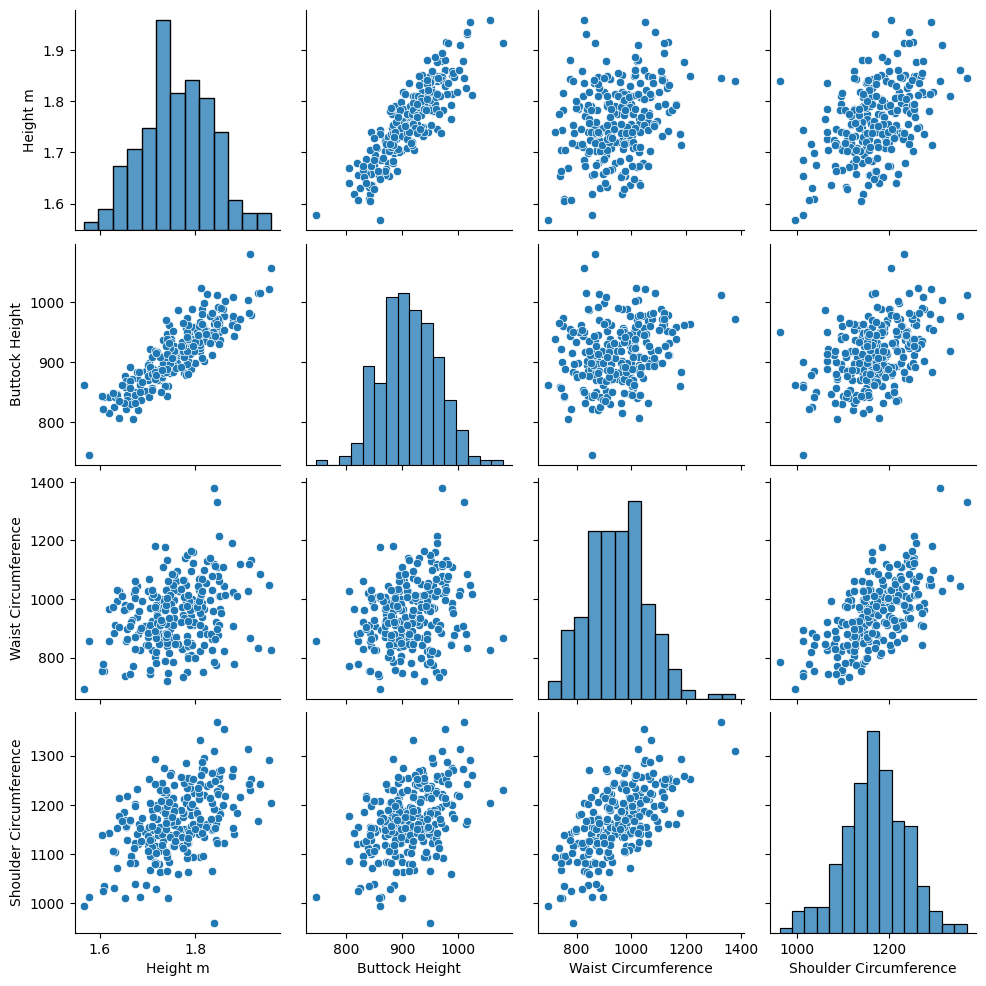

In [6]:
# Load df
ansur_df = pd.read_csv('../_datasets/ansur_sample.csv')

# Creating a pairplot to inspect ansur_df
sns.pairplot(ansur_df)

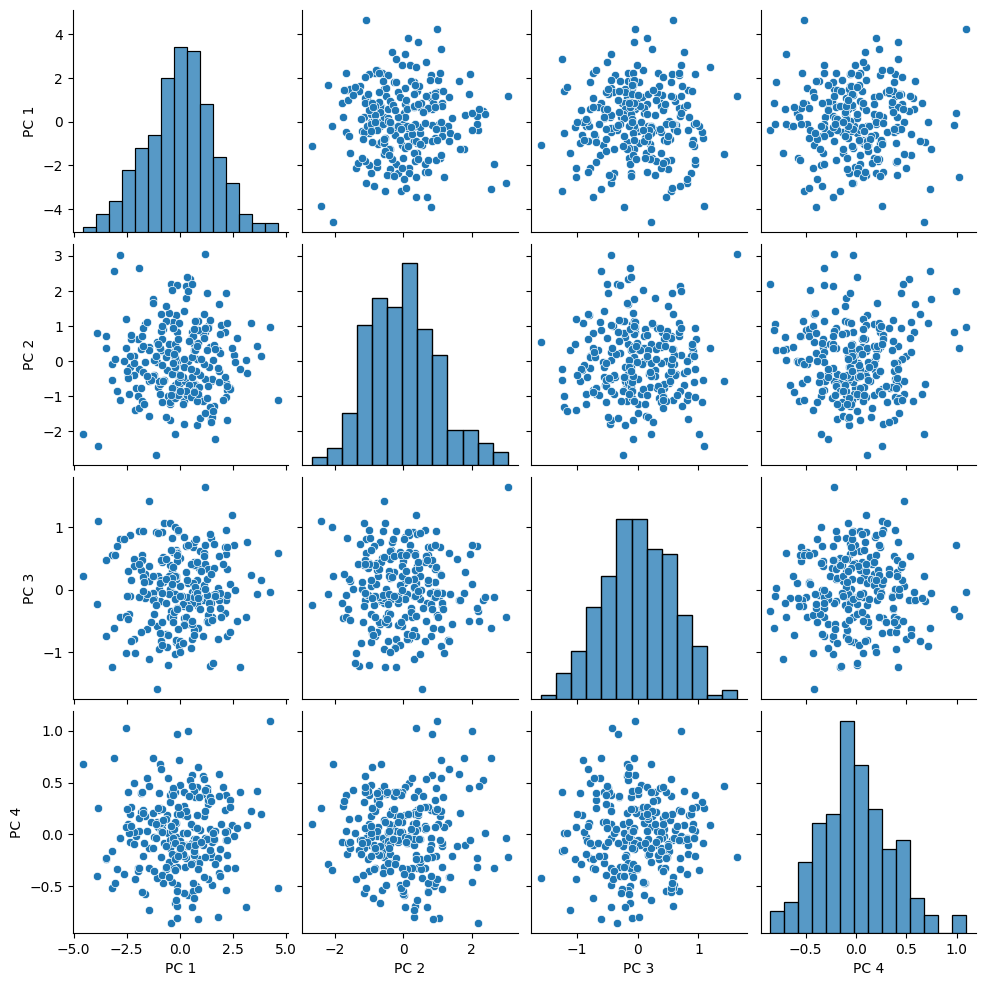

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Create the scaler and standardize the data
scaler = StandardScaler()
ansur_std = scaler.fit_transform(ansur_df)

# Creating the PCA instance and fit and transforming the data with pca
pca = PCA()
pc = pca.fit_transform(ansur_std)

# This changes the numpy array output back to a dataframe
pc_df = pd.DataFrame(pc, columns=['PC 1', 'PC 2', 'PC 3', 'PC 4'])

# Create a pairplot of the pricipal component dataframe
sns.pairplot(pc_df)

Notice how, in contrast to the input features, none of the principal components are correlated to one another.

### PCA on a larger dataset

You'll now apply PCA on a somewhat larger ANSUR datasample with 13 dimensions, once again pre-loaded as ansur_df. The fitted model will be used in the next exercise. Since we are not using the principal components themselves there is no need to transform the data, instead, it is sufficient to fit pca to the data.
  
- Create the scaler.
- Standardize the data.
- Create the `PCA()` instance.
- Fit it to the standardized data.

In [8]:
# Load df
df = pd.read_csv('../_datasets/ANSUR_II_MALE.csv')

ansur_df = df[['stature_m', 'buttockheight', 'waistdepth', 'span', 
               'waistcircumference', 'shouldercircumference', 'footlength', 
               'handlength', 'functionalleglength', 'chestheight', 
               'chestcircumference', 'cervicaleheight', 'sittingheight']]

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Scale the data
scaler = StandardScaler()
ansur_std = scaler.fit_transform(ansur_df)

# Apply PCA
pca = PCA()
pca.fit(ansur_std)

PCA()

You've fitted PCA on our 13 feature datasample. Now let's see how the components explain the variance.

### PCA explained variance

You'll be inspecting the variance explained by the different principal components of the pca instance you created in the previous exercise.
  
- Print the explained variance ratio per principal component.
- Calculate the cumulative sum of the explained variance ratio using a method of `pca.explained_variance_ratio_`.

In [10]:
# Inspecting the explained variance ratio per component
print(pca.explained_variance_ratio_)

[0.57832831 0.2230137  0.06404218 0.04252456 0.0278581  0.01761021
 0.01681037 0.01014147 0.00706488 0.00607973 0.00344643 0.00228095
 0.00079911]


In [11]:
# Print the cumulative sum of the explained variance ratio
print(pca.explained_variance_ratio_.cumsum())

[0.57832831 0.801342   0.86538419 0.90790875 0.93576684 0.95337706
 0.97018743 0.9803289  0.98739378 0.99347351 0.99691994 0.99920089
 1.        ]


The lowest number of principal components you should keep if you don't want to lose more than 10% of explained variance during dimensionality reduction is 4 principal components. We can explain more than 90% of the variance in the 13 feature dataset with the first 4.

## PCA applications

**PCA applications**
  
When you use PCA for dimensionality reduction you decide how much of the explained variance you're willing to sacrifice. However, one downside of PCA is that the remaining components can be hard to interpret.
  
**Understanding the components**
  
To improve your understanding of the components it can help to look at the `.components_` attribute. This tells us to what extent each component's vector is affected by a particular feature. The features with the biggest positive or negative effects on a component can then be used to add a meaning to that component. In the example shown here the effects of the features on the first components are positive and equally strong at 0.71. So the first component is affected just as much by hand as foot length. However, the second component is negatively affected by hand length. So people who score high for the second component have short hands compared to their feet.
  
**PCA for data exploration**
  
When we apply this technique to the combined male-female ANSUR dataset we find that the first component is mostly affected by overall body height. To verify this I've added body height categories to the data. When we plot the first two components and color the points with these categories, we can see that they pretty much align with the X-axis or first principal component. We therefore learn that the most important source of variance in this dataset, has something to do with how tall a person is.

**PCA in a pipeline**
  
Let's look at the code to create this plot. Since we always scale the data before applying PCA we can combine both operations in a pipeline. We pass the two operations to the `Pipeline()` class in the form of two tuples inside a list. Within each tuple we give our operation a name, 'scaler' and 'reducer' in this example, and then fit and transform the data in one go.
  
**Checking the effect of categorical features**
  
Our ANSUR dataset has a number of categorical features. PCA is not the preferred algorithm to reduce the dimensionality of categorical datasets, but we can check whether they align with the most important sources of variance in the data.  
We can add the first two principal components to our DataFrame and plot them with Seaborn's `scatterplot()`. To create the plot we saw earlier we set the hue parameter to 'Height_class'. Now that we know that tall individuals are on the left and shorter individuals on the right, let's have a look at how Gender is associated with the variance.  
It turns out females are mostly on the right, shorter side of our point cloud. When we use the BMI class to color the points we see that this feature is mostly aligned with the second principal component while also the first component has an effect.
  
**PCA in a model pipeline**
  
To go beyond data exploration, we can add a model to the pipeline. In this case, we've added a random forest classifier and will predict gender on the 94 numeric features of the ANSUR dataset. Notice that we've told the PCA class to only calculate 3 components with the `n_components=` parameter. We can access the different steps in the pipeline by using the names we gave each step as keys, just like a Python dictionary. When we use 'reducer' as the key, the PCA object is returned.  
Once the pipeline has been fitted to the data, we can access attributes like the `.explained_variance_ratio_` like so. When we sum these, we see that the first three components only explain 74% of the variance in the dataset. However, when we check the classification accuracy on the test set, we get an impressive 98.6%!

### Understanding the components
  
You'll apply PCA to the numeric features of the Pokemon dataset, poke_df, using a pipeline to combine the feature scaling and PCA in one go. You'll then interpret the meanings of the first two components.

In [15]:
df = pd.read_csv('../_datasets/pokemon.csv')
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [16]:
poke_df = df[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
poke_df.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,45,49,49,65,65,45
1,60,62,63,80,80,60
2,80,82,83,100,100,80
3,80,100,123,122,120,80
4,39,52,43,60,50,65


In [17]:
from sklearn.pipeline import Pipeline


# Building the pipeline
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components=2))
    ]
)

# Fitting the pipeline to the dataset and extracting the component vectors
pipe.fit(poke_df)
vectors = pipe.steps[1][1].components_.round(2)

# Displaying feature effects
print('PC 1 effects =' + str(dict(zip(poke_df.columns, vectors[0]))))
print('PC 2 effects =' + str(dict(zip(poke_df.columns, vectors[1]))))

PC 1 effects ={'HP': 0.39, 'Attack': 0.44, 'Defense': 0.36, 'Sp. Atk': 0.46, 'Sp. Def': 0.45, 'Speed': 0.34}
PC 2 effects ={'HP': 0.08, 'Attack': -0.01, 'Defense': 0.63, 'Sp. Atk': -0.31, 'Sp. Def': 0.24, 'Speed': -0.67}


In PC1, All features have a similar positive effect. PC 1 can be interpreted as a measure of overall quality (high stats).  
  
In contrast, PC2's defense has a strong positive effect on the second component and speed has a strong negative one. This component quantifies an agility vs. armor & protection trade-off.

### PCA for feature exploration
  
You'll use the PCA pipeline you've built in the previous exercise to visually explore how some categorical features relate to the variance in poke_df. These categorical features (Type & Legendary) can be found in a separate dataframe poke_cat_df.

In [18]:
poke_cat_df = df[['Type 1', 'Legendary']]

In [19]:
# Building the pipeline
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components=2))
    ]
)

# Fitting the pipeline to the poke_df
pc = pipe.fit_transform(poke_df)

print(pc)

[[-1.5563747  -0.02148212]
 [-0.36286656 -0.05026854]
 [ 1.28015158 -0.06272022]
 ...
 [ 2.45821626 -0.51588158]
 [ 3.5303971  -0.95106516]
 [ 2.23378629  0.53762985]]


In [23]:
# Adding the 2 components to the poke_cat_df
poke_cat_df.loc[:, 'PC 1'] = pc[:, 0]  # All rows, feature name, from pc all observations, col index
poke_cat_df.loc[:, 'PC 2'] = pc[:, 1]  # All rows, feature name, from pc all observations, col index

poke_cat_df.head()

/var/folders/pf/_zjf_55d7mgb5llg516d7fyc0000gn/T/ipykernel_2215/2903586632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poke_cat_df.loc[:, 'PC 1'] = pc[:, 0]  # All rows, feature name, from pc all observations, col index
/var/folders/pf/_zjf_55d7mgb5llg516d7fyc0000gn/T/ipykernel_2215/2903586632.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poke_cat_df.loc[:, 'PC 2'] = pc[:, 1]  # All rows, feature name, from pc all observations, col index


,Type 1,Legendary,PC 1,PC 2
0,Grass,False,-1.556375,-0.021482
1,Grass,False,-0.362867,-0.050269
2,Grass,False,1.280152,-0.062720
3,Grass,False,2.620916,0.704263
4,Fire,False,-1.758284,-0.706179


<Axes: xlabel='PC 1', ylabel='PC 2'>

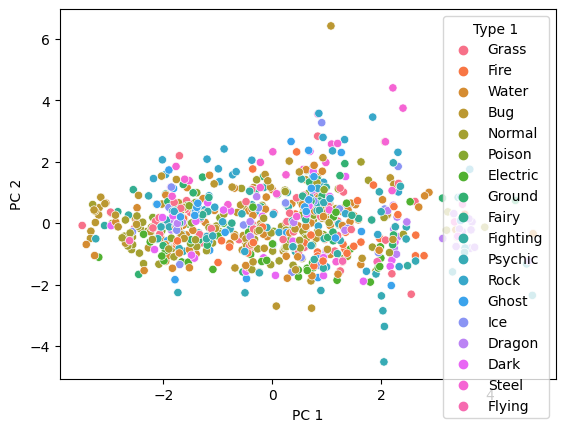

In [24]:
# Using the Type feature to color the PC1 vs PC2 scatterplot
sns.scatterplot(data=poke_cat_df, x='PC 1', y='PC 2', hue='Type 1')

<Axes: xlabel='PC 1', ylabel='PC 2'>

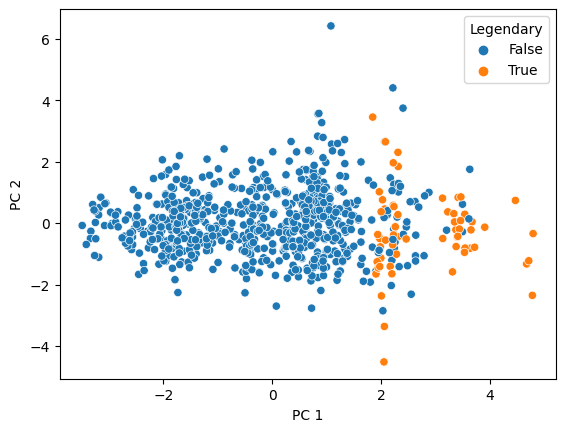

In [25]:
# Using the Legendary feature to color the PC1 vs PC2 scatterplot
sns.scatterplot(data=poke_cat_df, x='PC 1', y='PC 2', hue='Legendary')

Looks like the different types are scattered all over the place while the legendary Pokemon always score high for PC 1 meaning they have high stats overall. Their spread along the PC 2 axis tells us they aren't consistently fast and vulnerable or slow and armored.

### PCA in a model pipeline
  
We just saw that legendary Pokemon tend to have higher stats overall. Let's see if we can add a classifier to our pipeline that detects legendary versus non-legendary Pokemon based on the principal components.

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


# Seeding model
SEED = 0

# X/y split
X = poke_df
y = df['Legendary']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [27]:
# Building the pipeline
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components=2)),
        ('classifier', RandomForestClassifier(random_state=SEED))
    ]
)

# Fitting the pipeline to the training data
pipe.fit(X_train, y_train)

# Displaying the variance ratios
print(pipe.steps[1][1].explained_variance_ratio_)

# Scoring the accuracy on the test set
accuracy = pipe.score(X_test, y_test)

# Displaying the accuracy of the model
print('{0:.1%} test set accuracy'.format(accuracy))

[0.45673596 0.18599109]
92.1% test set accuracy


Repeating the process with 3 extracted components

In [28]:
# Building the pipeline
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components=3)),
        ('classifier', RandomForestClassifier(random_state=SEED))
    ]
)

# Fitting the pipeline to the training data
pipe.fit(X_train, y_train)

# Displaying the variance ratios
print(pipe.steps[1][1].explained_variance_ratio_)

# Scoring the accuracy on the test set
accuracy = pipe.score(X_test, y_test)

# Displaying the accuracy of the model
print('{0:.1%} test set accuracy'.format(accuracy))

[0.45673596 0.18599109 0.12852181]
93.8% test set accuracy


Repeating the process with 4 extracted components

In [29]:
# Building the pipeline
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components=4)),
        ('classifier', RandomForestClassifier(random_state=SEED))
    ]
)

# Fitting the pipeline to the training data
pipe.fit(X_train, y_train)

# Displaying the variance ratios
print(pipe.steps[1][1].explained_variance_ratio_)

# Scoring the accuracy on the test set
accuracy = pipe.score(X_test, y_test)

# Displaying the accuracy of the model
print('{0:.1%} test set accuracy'.format(accuracy))

[0.45673596 0.18599109 0.12852181 0.11442161]
95.0% test set accuracy


Repeating the process with 5 extracted components

In [32]:
# Building the pipeline
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components=5)),
        ('classifier', RandomForestClassifier(random_state=SEED))
    ]
)

# Fitting the pipeline to the training data
pipe.fit(X_train, y_train)

# Displaying the variance ratios
print(pipe.steps[1][1].explained_variance_ratio_)

# Scoring the accuracy on the test set
accuracy = pipe.score(X_test, y_test)

# Displaying the accuracy of the model
print('{0:.1%} test set accuracy'.format(accuracy))

[0.45673596 0.18599109 0.12852181 0.11442161 0.07054521]
95.8% test set accuracy


Repeating the process with 6 extracted components

In [33]:
# Building the pipeline
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components=6)),
        ('classifier', RandomForestClassifier(random_state=SEED))
    ]
)

# Fitting the pipeline to the training data
pipe.fit(X_train, y_train)

# Displaying the variance ratios
print(pipe.steps[1][1].explained_variance_ratio_)

# Scoring the accuracy on the test set
accuracy = pipe.score(X_test, y_test)

# Displaying the accuracy of the model
print('{0:.1%} test set accuracy'.format(accuracy))

[0.45673596 0.18599109 0.12852181 0.11442161 0.07054521 0.04378432]
95.0% test set accuracy


Looks like adding the sixth component does not increase the model accuracy, even though it adds information to the dataset.

## Principal Component Selection
  
**Principal Component selection**
  
In the previous lesson we saw how you can set the number of components that the PCA algorithm should calculate. An alternative technique is telling PCA the minimal proportion of variance we want to keep and let the algorithm decide on the number of components it needs to achieve that.
  
**Setting an explained variance threshold**
  
We can do this by passing a number between 0 and 1 to the `n_components=` parameter of PCA. When we pass it 0.9 it will make sure to select enough components to explain 90% of the variance. This turns out to be 5 for the Pokemon data. One problem is that whether we set the number of components as an integer or a ratio, we're still just making these numbers up using gut feeling. Fact is, there is not a single right answer to the question "how many components should I keep?" since it depends on how much information you are willing to sacrifice to reduce complexity.
  
**An optimal number of components**
  
There is, however, a trick that can help you find a good balance. When you plot the explained variance ratio of a fitted PCA instance, you'll get to see that most of the explained variance is concentrated in the first few components. As you go from left to right in this type of plot you'll often see that the explained variance ratio per component starts to level out quite abruptly. The location where this shift happens is known as the 'elbow' in the plot. 
  
![Alt text](../_images/optimal_num_components_pca.png)  
  
It typically gives you a good starting point for the number of components to keep. Do note that the x-axis shows you the index of the components and not the total number. So since the elbow is at the component with index 1 here, we'd select 2 components.
  
**PCA operations**
  
Up until now, we've seen how you can use PCA to go from an input feature dataset X to a NumPy array of principal components pc, either by first fitting pca to the data and then transforming that data in two operations or in one go with the `.fit_transform()` method. A final trick that I'd like to teach you, is how to go back from the principal components to the original feature space.
  
![Alt text](../_images/pca_op.png)  
  
This can be done by calling the `.inverse_transform()` method on the principal component array. Because you typically lose information going from left to right in this overview, you'll see that the result from going back to the original feature space will have changed somewhat.
  
**Compressing images**
  
An application where this is relevant is image compression. Let's have a look at the "Labeled Faces in the Wild" dataset. The 15 images you see here are the test set. It's a two dimensional NumPy array with 15 arrays of 2914 elements each. These elements correspond to the grayscale value of a pixel in the 62 by 47 pixel images. Our training set contains 1333 of such images.
  
We can build a pipeline where we tell PCA to select only 290 components and then fit this pipeline to our training data. If we then use this fitted model to transform the unseen test data, we'll get a 10 fold reduction in the number of features. We could now save our images with 10 times less disk space!
  
**Rebuilding images**
  
Finally, we can perform the inverse transform operation to rebuild our pixels from the principal components. We then use a custom made `img_plotter()` function to create this output. While there is quality loss, the result is not bad.
  
![Alt text](../_images/pca_quality_loss_with_inverse.png)  
  

### Selecting the proportion of variance to keep
  
You'll let PCA determine the number of components to calculate based on an explained variance threshold that you decide.

In [36]:
ansur_df = pd.read_csv('../_datasets/ANSUR_II_FEMALE.csv')
ansur_df.head()

,Branch,Component,Gender,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,...,waistdepth,waistfrontlengthsitting,waistheightomphalion,wristcircumference,wristheight,weight_kg,stature_m,BMI,BMI_class,Height_class
0,Combat Support,Regular Army,Female,231,1282,301,204,1180,222,177,...,217,345,942,152,756,65.7,1.560,26.997041,Overweight,Normal
1,Combat Service Support,Regular Army,Female,194,1379,320,207,1292,225,178,...,168,329,1032,155,815,53.4,1.665,19.262506,Normal,Normal
2,Combat Service Support,Regular Army,Female,183,1369,329,233,1271,237,196,...,159,367,1035,162,799,66.3,1.711,22.647148,Normal,Tall
3,Combat Service Support,Regular Army,Female,261,1356,306,214,1250,240,188,...,235,371,999,173,818,78.2,1.660,28.378575,Overweight,Normal
4,Combat Arms,Regular Army,Female,309,1303,308,214,1210,217,182,...,300,380,911,152,762,88.6,1.572,35.853259,Overweight,Normal


In [37]:
ansur_df.drop(['Gender', 'Branch', 'Component', 'BMI_class', 'Height_class'], 
              axis=1, inplace=True)
ansur_df.shape

(1986, 94)

In [38]:
# Pipeline a scaler to PCA to select 80% of the variance
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components=0.8))
    ]
)

# Fitting the pipeline to the dataset
pipe.fit(ansur_df)

print('{} components selected'.format(len(pipe.steps[1][1].components_)))

11 components selected


In [39]:
# Pipeline a scaler to PCA to select 90% of the variance
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components=0.9))
    ]
)

# Fitting the pipeline to the dataset
pipe.fit(ansur_df)

print('{} components selected'.format(len(pipe.steps[1][1].components_)))

23 components selected


From the result, we need more than 12 components to go from 80% to 90% explained variance.

### Choosing the number of components
  
You'll now make a more informed decision on the number of principal components to reduce your data to using the "elbow in the plot" technique.

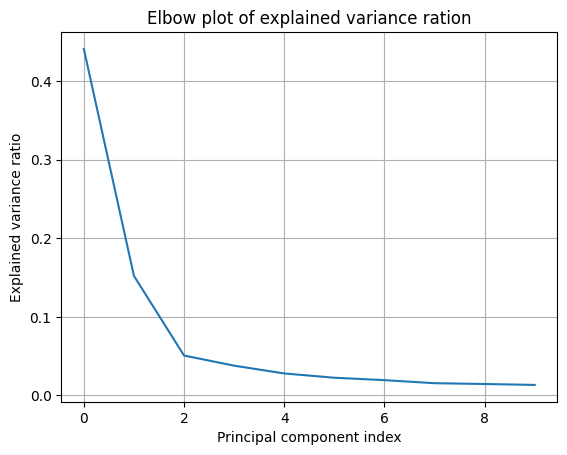

In [41]:
# Pipeline a scaler to PCA selecting 10 components
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components=10))
    ]
)

# Fitting the pipeline to the dataset
pipe.fit(ansur_df)

# Plotting the explained variance ratio
plt.plot(pipe.steps[1][1].explained_variance_ratio_)
plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.title('Elbow plot of explained variance ration')
plt.grid(True)
plt.show()

The 'elbow' in the plot is at 3 components (the 3rd component has index 2).

### PCA for image compression
  
You'll reduce the size of 16 images with hand written digits (MNIST dataset) using PCA.
  
The samples are 28 by 28 pixel gray scale images that have been flattened to arrays with 784 elements each (28 x 28 = 784) and added to the 2D numpy array X_test. Each of the 784 pixels has a value between 0 and 255 and can be regarded as a feature.
  
A pipeline with a scaler and PCA model to select 78 components has been pre-loaded for you as pipe. This pipeline has already been fitted to the entire MNIST dataset except for the 16 samples in X_test.

In [85]:
def plot_digits(data, num_digits=4, num_rows=2):
    data_array = data.values if isinstance(data, pd.DataFrame) else data

    fig, axes = plt.subplots(num_rows, num_digits, figsize=(10, 4),
                             subplot_kw={'xticks': [], 'yticks': []},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))

    for i, ax in enumerate(axes.flat):
        ax.imshow(data_array[i].reshape(28, 28), cmap='binary')

    plt.show()

In [78]:
from sklearn.datasets import fetch_openml

X, y = X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_sample = X_test[:1600:100]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [79]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reducer', PCA(n_components=78))
])

pipe.fit(X_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('reducer', PCA(n_components=78))])

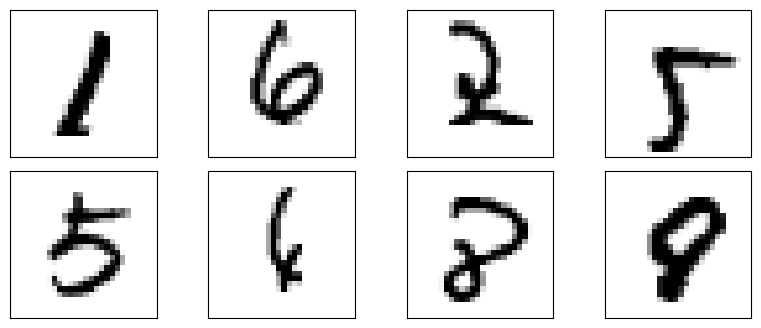

In [86]:
# Plot the MNIST sample data
plot_digits(X_sample)

In [90]:
# Transform the input data to principal components 
pc = pipe.transform(X_sample)

# Prints the number of features per dataset
print("X_sample has {} features".format(X_sample.shape[1]))
print("pc has {} features".format(pc.shape[1]))

X_sample has 784 features
pc has 78 features


In [88]:
# Inverse transform the components to original feature space
X_rebuilt = pipe.inverse_transform(pc)

# Prints the number of features
print("X_rebuilt has {} features".format(X_rebuilt.shape[1]))

X_rebuilt has 784 features


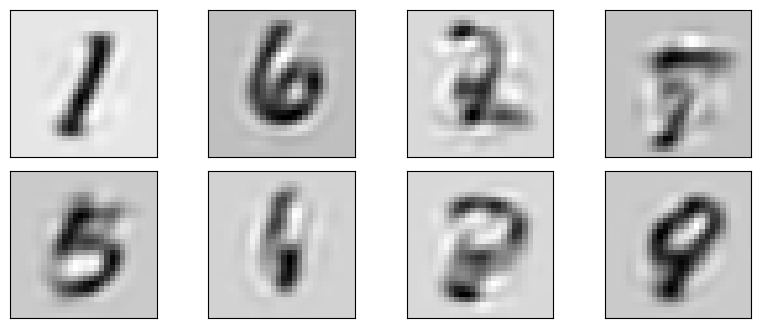

In [89]:
# Plot the reconstructed data
plot_digits(X_rebuilt)

You've reduced the size of the data 10 fold but were able to reconstruct images with reasonable quality.